In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline

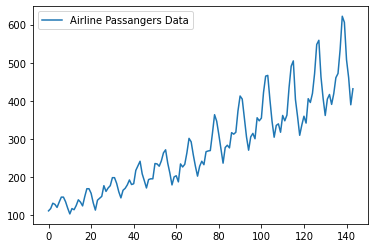

In [3]:
training_set = pd.read_csv('airline-passengers.csv')
training_set = training_set.iloc[:,1:2].values
plt.plot(training_set, label = 'Airline Passangers Data')
plt.legend()
plt.show()

In [7]:
training_set[:10]

array([[112],
       [118],
       [132],
       [129],
       [121],
       [135],
       [148],
       [148],
       [136],
       [119]], dtype=int64)

In [4]:
# series to supervision
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)
    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

# 训练集测试集大小
train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = torch.Tensor(np.array(x)).requires_grad_(True)
dataY = (torch.Tensor(np.array(y))).requires_grad_(True)

trainX = torch.Tensor(np.array(x[0:train_size])).requires_grad_(True)
trainY = torch.Tensor(np.array(y[0:train_size])).requires_grad_(True)

testX = torch.Tensor(np.array(x[train_size:len(x)]))
testY = torch.Tensor(np.array(y[train_size:len(y)]))

In [5]:
# 测试用

def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length+1 -1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)
    return np.array(x),np.array(y)

test__x = [1,2,3,4,5]
xxxx, yyyy = sliding_windows(test__x, 2)
xxxx,yyyy

(array([[1, 2],
        [2, 3],
        [3, 4]]),
 array([3, 4, 5]))

In [14]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        # self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)
        
        c_0 = torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [15]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.05914
Epoch: 100, loss: 0.00434
Epoch: 200, loss: 0.00352
Epoch: 300, loss: 0.00253
Epoch: 400, loss: 0.00200
Epoch: 500, loss: 0.00180
Epoch: 600, loss: 0.00174
Epoch: 700, loss: 0.00171
Epoch: 800, loss: 0.00170
Epoch: 900, loss: 0.00169
Epoch: 1000, loss: 0.00168
Epoch: 1100, loss: 0.00166
Epoch: 1200, loss: 0.00165
Epoch: 1300, loss: 0.00163
Epoch: 1400, loss: 0.00161
Epoch: 1500, loss: 0.00159
Epoch: 1600, loss: 0.00158
Epoch: 1700, loss: 0.00158
Epoch: 1800, loss: 0.00157
Epoch: 1900, loss: 0.00157


In [16]:
trainX[:5],trainY[:5]

(tensor([[[0.0154],
          [0.0270],
          [0.0541],
          [0.0483]],
 
         [[0.0270],
          [0.0541],
          [0.0483],
          [0.0328]],
 
         [[0.0541],
          [0.0483],
          [0.0328],
          [0.0598]],
 
         [[0.0483],
          [0.0328],
          [0.0598],
          [0.0849]],
 
         [[0.0328],
          [0.0598],
          [0.0849],
          [0.0849]]], grad_fn=<SliceBackward>),
 tensor([[0.0328],
         [0.0598],
         [0.0849],
         [0.0849],
         [0.0618]], grad_fn=<SliceBackward>))

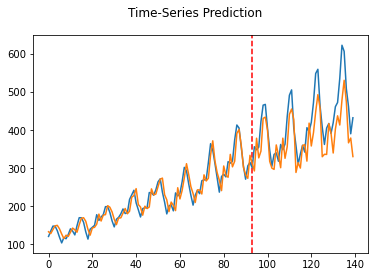

In [17]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()